Import necessary libraries
Please ensure that the Python version does not exceed 3.9

In [15]:
import pandas as pd
import networkx as nx
from itertools import combinations
import matplotlib.pyplot as plt
import numpy as np

Verify the size and accessibility of data

In [3]:
# Select three datasets, large, medium, and small, as required
df_large = pd.read_csv('USERS.csv')
# data check
print(df_large.head())

print('Large Dataset:')
print('data size:', df_large.size)
print('data shape:', df_large.shape)  # returns (rows, columns)

  thread_subject        username                          page_name
0     No subject  Liuxinyu970226  Usertalk000accountdeleted000.json
1     No subject      M2k~dewiki          Usertalk000selina000.json
2     No subject        Peaceray                Usertalk001Jrm.json
3     No subject  Liuxinyu970226             Usertalk007hemant.json
4     No subject          ToJack           Usertalk011ZezoTito.json
Large Dataset:
data size: 515076
data shape: (171692, 3)


Functions for constructing networks

In [4]:
def build_editor_network(df):
    G = nx.Graph()
    user_ids = {}  # 存储用户对应节点编号
    next_id = 0

    # 遍历每一个话题(thread)，并建立用户之间的连接
    grouped = df.groupby(['page_name', 'thread_subject'])
    
    for (page, thread), group in grouped:
        users = group['username'].unique()
        
        # 为每个用户分配ID
        for user in users:
            if user not in user_ids:
                user_ids[user] = next_id
                next_id += 1
                
        # 为在同一页面同一线程下评论的用户建立边
        for user_pair in combinations(users, 2):
            u1, u2 = user_ids[user_pair[0]], user_ids[user_pair[1]]
            if G.has_edge(u1, u2):
                G[u1][u2]['weight'] += 1
            else:
                G.add_edge(u1, u2, weight=1)
    
    return G, user_ids

In [5]:
G_large, user_ids_large = build_editor_network(df_large)

# Display basic network information
print("Network info：")
print(f"Nodes: {G_large.number_of_nodes()}")
print(f"Edges: {G_large.number_of_edges()}")
print(f"Network density index: {nx.density(G_large):.6f}")


Network info：
Nodes: 8390
Edges: 24692
Network density index: 0.000702


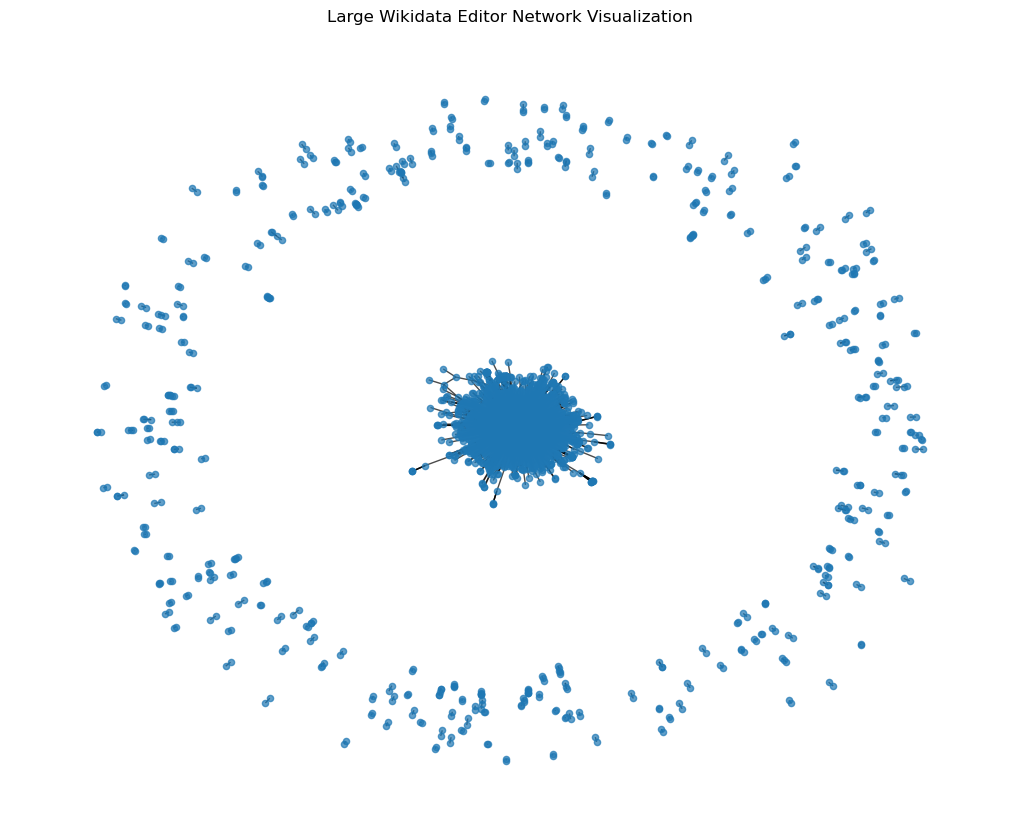

In [6]:
plt.figure(figsize=(10, 8))
nx.draw(G_large, node_size=20, alpha=0.7)
plt.title('Large Wikidata Editor Network Visualization')
plt.show()

In [7]:
# 网络基本信息
num_nodes = G_large.number_of_nodes()
num_edges = G_large.number_of_edges()
density = nx.density(G_large)
clustering_coeff = nx.average_clustering(G_large)

print("Basic network indicators：")
print(f"nodes: {num_nodes}")
print(f"edges: {num_edges}")
print(f"Network density: {density:.4f}")
print(f"Average clustering coefficient: {clustering_coeff:.4f}")

Basic network indicators：
nodes: 8390
edges: 24692
Network density: 0.0007
Average clustering coefficient: 0.2480


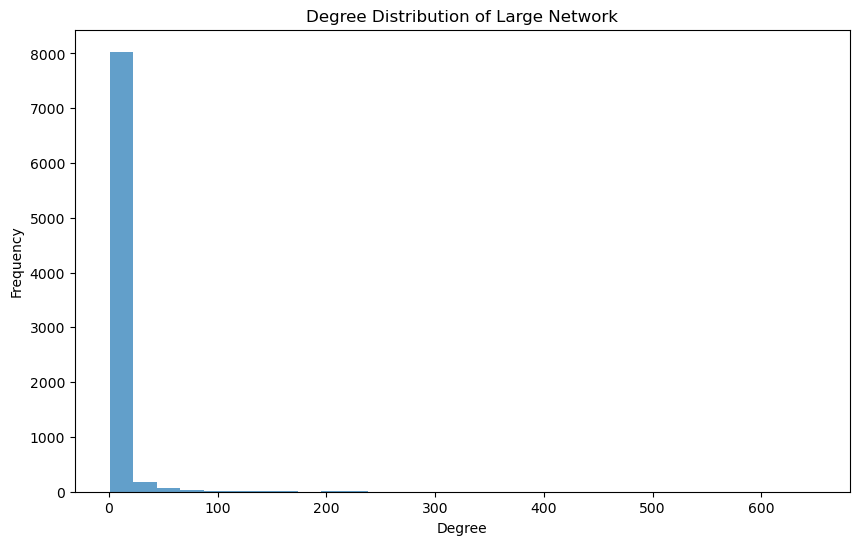

In [7]:
degrees = [degree for node, degree in G_large.degree()]
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=30, alpha=0.7)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution of Large Network')
plt.show()

In [8]:
degree_centrality = nx.degree_centrality(G_large)

# Show the top 5 most important nodes
top5_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Degree centrality of top 5 nodes:")
for node, centrality in top5_nodes:
     print(f"Node {node}: centrality={centrality:.4f}")

Degree centrality of top 5 nodes:
Node 24: centrality=0.0774
Node 17: centrality=0.0674
Node 233: centrality=0.0473
Node 19: centrality=0.0468
Node 98: centrality=0.0445


In [9]:
if nx.is_connected(G_large):
    avg_path_length = nx.average_shortest_path_length(G_large)
    diameter = nx.diameter(G_large)
else:
    # If not fully connected, only calculate the largest connected subgraph
    largest_cc = max(nx.connected_components(G_large), key=len)
    G_largest_cc = G_large.subgraph(largest_cc)
    
    avg_path_length = nx.average_shortest_path_length(G_largest_cc)
    diameter = nx.diameter(G_largest_cc)

print(f"Average shortest path length: {avg_path_length:.4f}")
print(f"network diameter: {diameter}")


Average shortest path length: 3.6356
network diameter: 10


In [10]:
G_random = nx.gnm_random_graph(num_nodes, num_edges)

# Calculate the average clustering coefficient and path length of a random network
random_clustering = nx.average_clustering(G_random)
if nx.is_connected(G_random):
    random_path_length = nx.average_shortest_path_length(G_random)
else:
    largest_cc_random = max(nx.connected_components(G_random), key=len)
    G_random_cc = G_random.subgraph(largest_cc_random)
    random_path_length = nx.average_shortest_path_length(G_random_cc)

print("Random network metrics：")
print(f"Random network average clustering coefficient: {random_clustering:.4f}")
print(f"Average shortest path length of random network: {random_path_length:.4f}")



Random network metrics：
Random network average clustering coefficient: 0.0009
Average shortest path length of random network: 5.2941


In [11]:
comparison = pd.DataFrame({
    "Metric": ["Clustering Coefficient", "Average Path Length"],
    "Wikidata Network": [clustering_coeff, avg_path_length],
    "Random Network": [random_clustering, random_path_length]
})

print(comparison)


                   Metric  Wikidata Network  Random Network
0  Clustering Coefficient          0.247988        0.000913
1     Average Path Length          3.635581        5.294086


In [14]:
suspected_trolls = np.random.choice(G_large.nodes(), 2, replace=False)
print("Suspected troll nodes:", suspected_trolls)

# Calculate the shortest path between suspected troll nodes
if nx.has_path(G_large, suspected_trolls[0], suspected_trolls[1]):
    shortest_path = nx.shortest_path(G_large, suspected_trolls[0], suspected_trolls[1])
    print(f"The shortest path length between two suspected nodes: {len(shortest_path)-1}")
    print("The path is:", shortest_path)
else:
    print("There is no direct or indirect path between the two suspected nodes.")


Suspected troll nodes: [6503 7459]
The shortest path length between two suspected nodes: 3
The path is: [6503, 372, 1605, 7459]


In [19]:
# 度中心性识别重要节点
degree_centrality = nx.degree_centrality(G_large)

# 对中心性进行排序（降序）
sorted_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

# 显示优先监测的前10个节点
top_priority = sorted_centrality[:10]
print("Editor with priority monitoring (based on degree_centrality):")
for node, centrality in top_priority:
    print(f"Node{node}，degree_centrality：{centrality:.4f}")


Editor with priority monitoring (based on degree_centrality):
Node24，degree_centrality：0.0774
Node17，degree_centrality：0.0674
Node233，degree_centrality：0.0473
Node19，degree_centrality：0.0468
Node98，degree_centrality：0.0445
Node258，degree_centrality：0.0439
Node711，degree_centrality：0.0387
Node56，degree_centrality：0.0379
Node13，degree_centrality：0.0343
Node222，degree_centrality：0.0333


In [17]:
def simple_SIR(G, initial_infected, beta=0.3, gamma=0.1, steps=10):
    infected = set(initial_infected)
    recovered = set()
    susceptible = set(G.nodes()) - infected - recovered

    infection_history = [len(infected)]

    for step in range(steps):
        new_infected = set()
        for node in infected:
            neighbors = set(G.neighbors(node)) & susceptible
            for neighbor in neighbors:
                if np.random.random() < beta:
                    new_infected.add(neighbor)

        recovered.update(infected)
        infected = new_infected
        susceptible -= new_infected

        infection_history.append(len(infected))

        if not infected:
            break

    return infection_history


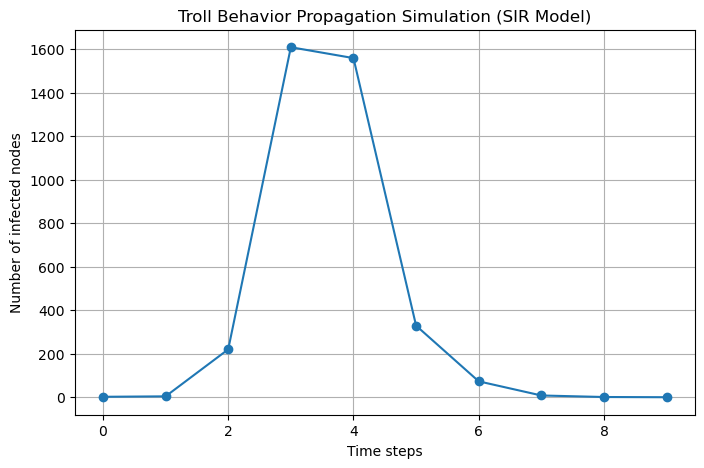

In [20]:
# 假设初始感染节点是疑似troll节点
initial_infected = suspected_trolls.tolist()

# 模拟传播过程
infection_history = simple_SIR(G_large, initial_infected)

# 绘制传播情况曲线
plt.figure(figsize=(8, 5))
plt.plot(infection_history, marker='o')
plt.xlabel('Time steps')
plt.ylabel('Number of infected nodes')
plt.title('Troll Behavior Propagation Simulation (SIR Model)')
plt.grid(True)
plt.show()
